# Softmax Regression | BoW sequence representation

Training a Bag-of-Words (BoW) based Softmax Regression model.  

Bag-of-Words Model used to represent the Feature Vector - numeric representation of the protein sequence. 

In [1]:
# Jupyter caches all library imports and only loads them once, unless restart the kernel
# when you update the .py files in src/, the changes are not picked up by Jupyter.
# to solve this, you just add these 2 lines at the beginning of your notebook.
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import argparse
import time
import torch
from torch.utils.data import Dataset, DataLoader

In [4]:
# Colab - connect Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/colabProteinProject/src/protein_universe_annotate')

In [6]:
from data_exploration import get_partitions_info

In [7]:
from data_processing import fit_count_vectorizer
from ProteinDataset import ProteinDataset
from ProteinModel import SoftmaxRegression, ProteinModel
from viz_tools import plot_loss_and_accuracy_curves

In [8]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 128
max_features = 1000

## Read filtered dataset

In [9]:
train_data_path = '/content/drive/MyDrive/colabProteinProject/data/train_filtered.csv'
test_data_path = '/content/drive/MyDrive/colabProteinProject/data/test_filtered.csv'
dev_data_path = '/content/drive/MyDrive/colabProteinProject/data/dev_filtered.csv'

output_dir = '/content/drive/MyDrive/colabProteinProject/outputs/softmax_reg'

In [10]:
# Read the data
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)
dev_df = pd.read_csv(dev_data_path)

In [11]:
get_partitions_info([train_df, dev_df, test_df], ['Train', 'Dev', 'Test'])

,partition,num_of_samples,num_of_true_class,max_samples_per_class,min_samples_per_class,min_seq_length,max_seq_length,avg_seq_length
0,Train,535614,1792,3637,127,30,300,121.708271
1,Dev,65939,1792,454,12,30,300,121.743339
2,Test,65913,1792,454,12,30,300,121.577382


In [12]:
# Get all input protein sequences to learn BoW feature representation
all_sequences = train_df['sequence'].tolist() + dev_df['sequence'].tolist() + test_df['sequence'].tolist()

In [13]:
# Fit CountVectorizer to learn the vocabulary and set indices for amino acids
ngrams_bow_model = fit_count_vectorizer(ngram_range=(1, 3), max_features=max_features,
                                        input_sequences=all_sequences)

In [14]:
num_features = len(ngrams_bow_model.vocabulary_)
num_classes = len(np.unique(np.concatenate((train_df["true_label_encoded"].values,
                                            test_df["true_label_encoded"].values,
                                            dev_df["true_label_encoded"].values))))

In [15]:
# Define a custom dataset class to be used with data loader object
datasets = {
    name: ProteinDataset(raw_seqs=data_df['sequence'],
                            seq_encoder=ngrams_bow_model,
                            labels=data_df["true_label_encoded"].values)
    for name, data_df in zip(['train', 'dev', 'test'], [train_df, dev_df, test_df])
}

In [16]:
# Create a data loader object for each partition
# Set shuffle parameter to True only for the training data loader
dataloaders = {
    name: DataLoader(datasets[name],
                        batch_size=batch_size,
                        shuffle=(name == 'train'))
    for name in datasets
}

In [17]:
# Checking the dataset
for seqs, labels in dataloaders['train']:  
    print('Batch *sequences* dimensions:', seqs.shape)
    print('Batch *labels* dimensions:', labels.shape)
    break

Batch *sequences* dimensions: torch.Size([128, 1000])
Batch *labels* dimensions: torch.Size([128])


## Softmax Regression Classifier

## Softmax regression

Softmax regression is a **linear** model that **generalizes logistic regression** to account for **multi-class problems**. It is used to establish a **baseline**.

\begin{align}
f_\theta(x) &= \text{Softmax}(xW+b)
\end{align}

Where:

* $f_\theta$ is the model with parameters $\theta = {W,b}$. 
* $x$ is the **bag-of-ngrams** input vector of size $q$ - size of BoW vocabulary.
* $W$ is the weight paremeters matrix of size $q \times c$ with $c$ being the number of classes.
* $b$ is the bias parameters vector of size $c$.

**Why softmax regression?** 
* Natural fit for multi-class classification with the softmax non-linearity enforcing the output to be a probability distribution over mutually exclusive classes.

In [18]:
# Architecture
num_features = num_features
num_classes = num_classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
# Initialize softmax regression model, loss function, and optimizer
softmax_regression_model = SoftmaxRegression(num_features=num_features,
                                             num_classes=num_classes)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(softmax_regression_model.parameters(), lr=learning_rate)

In [21]:
# Initialize ProteinModel with softmax regression model as a backbone for training and evaluation
model = ProteinModel(softmax_regression_model)

In [22]:
start_time = time.time()
epoch_loss = {'train': [], 'val': []}
epoch_acc = {'train': [], 'val': []}

for epoch in range(num_epochs):
    train_loss_avg, train_acc_total = model.train(dataloaders['train'], loss_fn, optimizer)
    val_loss_avg, val_acc_total = model.evaluate(dataloaders['dev'], loss_fn)

    epoch_loss['train'].append(train_loss_avg)
    epoch_loss['val'].append(val_loss_avg)
    epoch_acc['train'].append(train_acc_total)
    epoch_acc['val'].append(val_acc_total)

    print(f'\n[EPOCH:{epoch + 1:3d}/{num_epochs}]',
            f'train.loss: {train_loss_avg:.4f}',
            f'train.acc: {100 * train_acc_total:3.2f}%',
            f'val.loss: {val_loss_avg:.4f}',
            f'val.acc: {100 * val_acc_total:3.2f}%')
    print(f'Time elapsed: {((time.time() - start_time) / 60):.2f} mins \n')

Batch 0/4185, Loss: 7.8992, Accuracy: 0.00%
Batch 250/4185, Loss: 3.9775, Accuracy: 26.80%
Batch 500/4185, Loss: 2.1168, Accuracy: 42.99%
Batch 750/4185, Loss: 2.2189, Accuracy: 51.66%
Batch 1000/4185, Loss: 1.5289, Accuracy: 57.41%
Batch 1250/4185, Loss: 1.3306, Accuracy: 61.49%
Batch 1500/4185, Loss: 1.2321, Accuracy: 64.52%
Batch 1750/4185, Loss: 1.2007, Accuracy: 66.92%
Batch 2000/4185, Loss: 1.0828, Accuracy: 68.91%
Batch 2250/4185, Loss: 1.0258, Accuracy: 70.53%
Batch 2500/4185, Loss: 0.5884, Accuracy: 71.96%
Batch 2750/4185, Loss: 0.7321, Accuracy: 73.18%
Batch 3000/4185, Loss: 0.7033, Accuracy: 74.29%
Batch 3250/4185, Loss: 0.5942, Accuracy: 75.25%
Batch 3500/4185, Loss: 0.7214, Accuracy: 76.11%
Batch 3750/4185, Loss: 0.8157, Accuracy: 76.86%
Batch 4000/4185, Loss: 0.7333, Accuracy: 77.55%

[EPOCH:  1/10] train.loss: 0.0118 train.acc: 78.02% val.loss: 0.0049 val.acc: 88.44%
Time elapsed: 0.30 mins 

Batch 0/4185, Loss: 0.4047, Accuracy: 94.53%
Batch 250/4185, Loss: 0.4149, Accu

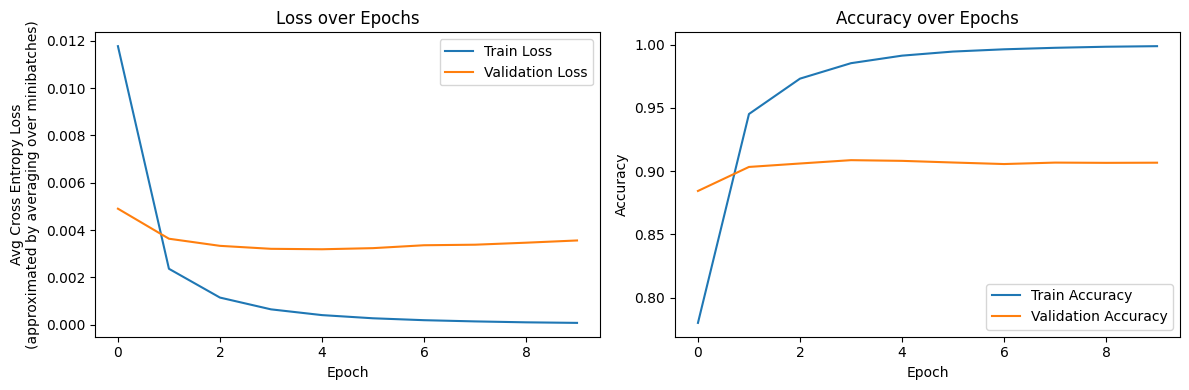

In [23]:
# Plot loss and accuracy curves
plot_loss_and_accuracy_curves(epoch_loss=epoch_loss, epoch_acc=epoch_acc, 
                              save_path=output_dir)

In [24]:
# Evaluate performance on the held-out test dataset
test_loss_total, test_acc_total = model.evaluate(dataloaders['test'], loss_fn)
print(f'[Test set performance]',
        f'test.loss: {test_loss_total:.4f}',
        f'test.acc: {100 * test_acc_total:3.2f}%')

[Test set performance] test.loss: 0.0037 test.acc: 90.56%


In [25]:
# Save the trained model
model.save_model(state_dict_model_path=f'{output_dir}/softmax_state_dict_model.pt')

In [26]:
# Predict the labels on the test dataset
test_predictions, test_acc = model.predict(dataloaders['test'])

In [27]:
# Save predicted labels
test_df['softmaxreg_preds'] = test_predictions
test_df.to_csv(f'{output_dir}/softmaxreg_test_preds.csv', index=False)

In [28]:
# Generate prediction for a random seq
# idx = np.random.randint(0, 100)
idx = 65
test_seq = test_df['sequence'].tolist()[idx]
test_label = test_df['true_label_encoded'].tolist()[idx]

In [29]:
# Encode the test seq and convert to tensor
test_encoded = ngrams_bow_model.transform([test_seq]).todense()
test_encoded = torch.tensor(test_encoded, dtype=torch.float32)

In [30]:
test_encoded.shape

torch.Size([1, 1000])

In [31]:
_, prediction = model.forward(test_encoded.to(device))
prediction = torch.argmax(prediction, dim=1).item()

In [32]:
print(f'Predicted label:{prediction} - True Label:{test_label}')

Predicted label:1618 - True Label:1618


In [33]:
# Generate prediction with the loaded model
softmax_model = SoftmaxRegression(num_features=num_features,
                                  num_classes=num_classes)

loaded_model = ProteinModel(softmax_model)
loaded_model.load_model(f'{output_dir}/softmax_state_dict_model.pt')

_, prediction = loaded_model.forward(test_encoded.to(device))
prediction = torch.argmax(prediction, dim=1).item()
print(f'Predicted label:{prediction} - True Label:{test_label}')

Predicted label:1618 - True Label:1618


**Observation**: 
- softmax regression achieves the accuracy on the test dataset: `test.acc: 90.63%`
- after 4 epochs, the improvement in performance is small. To prevent potential overfitting, the model is selected after 4 epochs using the early stopping technique
- n-grams BoW feature representation yields quite meaning encoding of protein sequence


Next steps to do / experiment with:
- Increase complexity of the model (add more FC layers prior to softmax)
- Have better hand-crafted feature representations (longer feature vector, different encoding technique) of the protein sequence 
- Switch to sequence models (to learn features without applying domain knowledge)



---



---



In [ ]:
## Save the sklearn.feature_extraction.text.CountVectorizer

In [34]:
from utils import save_count_vectorizer_params, save_count_vectorizer_vocab, load_count_vectorizer

In [35]:
save_count_vectorizer_params(ngrams_bow_model, output_dir)

CountVectorizer parameters saved at: /content/drive/MyDrive/colabProteinProject/outputs/softmax_reg/count_vectorizer_params.json


In [36]:
save_count_vectorizer_vocab(ngrams_bow_model, output_dir)

CountVectorizer vocabulary saved at: /content/drive/MyDrive/colabProteinProject/outputs/softmax_reg/count_vectorizer_vocab.json


In [37]:
# load the CountVectorizer
loaded_ngram_bow_model = load_count_vectorizer(cv_params_path='/content/drive/MyDrive/colabProteinProject/outputs/softmax_reg/count_vectorizer_params.json',
                                               cv_vocab_path='/content/drive/MyDrive/colabProteinProject/outputs/softmax_reg/count_vectorizer_vocab.json')

In [39]:
if loaded_ngram_bow_model.vocabulary_ == ngrams_bow_model.vocabulary_:
    print("The dictionaries have the same contents.")

The dictionaries have the same contents.


In [40]:
# Encode the test seq and convert to tensor
test_encoded_loaded = loaded_ngram_bow_model.transform([test_seq]).todense()
test_encoded_loaded = torch.tensor(test_encoded_loaded, dtype=torch.float32)

_, prediction = model.forward(test_encoded_loaded.to(device))
prediction = torch.argmax(prediction, dim=1).item()

print(f'Predicted label:{prediction} - True Label:{test_label}')

Predicted label:1618 - True Label:1618


In [41]:
# Use loaded ngrams bow model to define test dataset
test_dataset = ProteinDataset(raw_seqs=test_df['sequence'],
                              seq_encoder=loaded_ngram_bow_model,
                              labels=test_df["true_label_encoded"].values)

In [42]:
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False
                        )

In [43]:
# Evaluate performance on the held-out test dataset
test_loss_total, test_acc_total = model.evaluate(dataloaders['test'], loss_fn)
test_acc_total

0.9056483546493105



---



---



In [ ]:
## Learning how to save the CountVectorizer

In [ ]:
type(ngrams_bow_model)

sklearn.feature_extraction.text.CountVectorizer

In [ ]:
# Save a pickle - security risks
import pickle

with open(f'{output_dir}/ngrams_bow_model.pkl', 'wb') as fout:
    pickle.dump(ngrams_bow_model, fout)

In [ ]:
with open(f'{output_dir}/ngrams_bow_model.pkl', 'rb') as f:
    loaded_ngrams_bow_model_pickle = pickle.load(f)

In [ ]:
# Encode the test seq and convert to tensor
test_encoded_pickle = loaded_ngrams_bow_model_pickle.transform([test_seq]).todense()
test_encoded_pickle = torch.tensor(test_encoded_pickle, dtype=torch.float32)

_, prediction = model.forward(test_encoded_pickle.to(device))
prediction = torch.argmax(prediction, dim=1).item()

print(f'Predicted label:{prediction} - True Label:{test_label}')

Predicted label:1618 - True Label:1618


In [ ]:
if loaded_ngrams_bow_model_pickle.vocabulary_ == ngrams_bow_model.vocabulary_:
    print("The dictionaries have the same contents.")

The dictionaries have the same contents.


In [ ]:
### Save the parameters of the vectorizer

# Get the parameters of the CountVectorizer
ngrams_bow_model_params = ngrams_bow_model.get_params()

# Convert non-serializable values to JSON serializable types
for key, value in ngrams_bow_model_params.items():
    if isinstance(value, type):
        ngrams_bow_model_params[key] = str(value)

# Save the parameters to a JSON file
with open(f'{output_dir}/ngrams_bow_model_params.json', 'w') as f:
    json.dump(ngrams_bow_model_params, f, indent=4)

In [ ]:
# Just the vocabulary to avoid security risks (associated with pickle)
vocabulary = ngrams_bow_model.vocabulary_
vocabulary = {key: int(value) for key, value in vocabulary.items()}

with open(f'{output_dir}/ngrams_bow_model_vocab.json', 'w') as file:
    json.dump(vocabulary, file, indent=4)

In [ ]:
with open(f'{output_dir}/ngrams_bow_model_vocab.json', 'r') as file:
    vocabulary = json.load(file)

loaded_ngrams_bow_model = CountVectorizer(lowercase=False, analyzer='char', 
                                          ngram_range=(1, 3), max_features=max_features, 
                                          vocabulary=vocabulary)

In [ ]:
len(loaded_ngrams_bow_model.get_feature_names_out())

1000

In [ ]:
len(loaded_ngrams_bow_model.vocabulary_)

1000

In [ ]:
if loaded_ngrams_bow_model.vocabulary_ == ngrams_bow_model.vocabulary_:
    print("The dictionaries have the same contents.")

The dictionaries have the same contents.


In [ ]:
# Encode the test seq and convert to tensor
test_encoded_vocab = loaded_ngrams_bow_model.transform([test_seq]).todense()
test_encoded_vocab = torch.tensor(test_encoded_vocab, dtype=torch.float32)

_, prediction = model.forward(test_encoded_vocab.to(device))
prediction = torch.argmax(prediction, dim=1).item()

print(f'Predicted label:{prediction} - True Label:{test_label}')

Predicted label:1618 - True Label:1618


In [ ]:
# Use loaded ngrams bow model to define test dataset
test_dataset = ProteinDataset(raw_seqs=test_df['sequence'],
                              seq_encoder=loaded_ngrams_bow_model,
                              labels=test_df["true_label_encoded"].values)

In [ ]:
test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False
                        )

In [ ]:
# Evaluate performance on the held-out test dataset
test_loss_total, test_acc_total = model.evaluate(dataloaders['test'], loss_fn)
test_acc_total

0.9053297528560375